In [57]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, glob

import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

## Metricas satelite

In [58]:
sentinel_df = pd.read_csv("data/sentinel_reporte15junio.csv")
sentinel_df.head()

,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020
0,0600200010021,7.538192,0.052684,0.023191,41.378637,0.020715,Colima,Colima,Colima,1637,2
1,0600200010290,5.483005,0.038272,0.017147,30.207804,0.014379,Colima,Colima,Colima,2302,1
2,0600200010318,3.022569,0.020877,0.009553,16.584309,0.007864,Colima,Colima,Colima,1959,2
3,0600200010322,3.136248,0.021822,0.009879,17.287213,0.008218,Colima,Colima,Colima,2143,1
4,0600200010337,3.209967,0.022319,0.009966,17.647129,0.008404,Colima,Colima,Colima,1335,1


## Datos suelo y agua

### suelo 

#### Suelo loc

In [59]:
suelo_loc = pd.read_excel("data/sueloagua_informe15junio/Metadatos Suelo.xlsx", 
                      skiprows=6, sheet_name="SUELO")

# Ignore first 30 columns
suelo_loc = suelo_loc.iloc[:, 30:36]
suelo_loc.columns = ["no_muestra", "sitio_muestra", "id_muestra", "fecha_muestra", "x", "y"]
suelo_loc.drop(columns=["no_muestra"], inplace=True)
suelo_loc.head()

## check duplicates on id_muestra
suelo_loc[suelo_loc.duplicated(subset=["id_muestra"], keep=False)]

## remove duplicates and null rows
suelo_loc = suelo_loc.drop_duplicates(subset=["id_muestra"], keep="first")
suelo_loc = suelo_loc.dropna(subset=["id_muestra"])

lista = suelo_loc["id_muestra"].apply(lambda x: x if pd.isna(x) else x.split("-"))

# remove "A", "B" and " " from the last element of the list
lista = lista.apply(lambda x: [y.replace("A", "").replace("B", "").replace(" ", "") if i > 1 else y for i, y in enumerate(x)])
lista = lista.apply(lambda x: [y.zfill(2) if i > 1 else y for i, y in enumerate(x)])

# join the list again using "-" as separator and make it upper case
lista = lista.apply(lambda x: "-".join(x).upper())

# replace id_muestra column with the new one
suelo_loc["id_muestra"] = lista

# replace from id_muestra: "V. DE A."" to "VA"
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("V. DE A.", "VA")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("55", "SS")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("MZ", "MZN")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("Q", "QUE")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("CU", "CMO")
suelo_loc["sitio_muestra"] = suelo_loc["sitio_muestra"].str.replace(".", "")
suelo_loc["sitio_muestra"] = suelo_loc["sitio_muestra"].str.replace(",", "")

In [60]:
suelo_loc.sitio_muestra.unique()


array(['Tecomán', 'Quesería Colima', 'Manzanillo', 'Colima', 'Cuauhtémoc',
       'Estero Palo Verde Armeria', 'Villa de Álvarez',
       'Alzada Cuauhtémoc', 'Nogueras Colima', 'Canoas Manzanillo',
       'Minatitlán'], dtype=object)

In [61]:
suelo_loc.sitio_muestra.unique()

rename_sition = {
    'Quesería Colima': 'Quesería', 
    'Estero Palo Verde Armeria': 'Estero Palo Verde',
    'Alzada Cuauhtémoc': 'Alzada', 
    'Nogueras Colima': 'Nogueras',
    'Canoas Manzanillo': 'Canoas',
}

suelo_loc["sitio_muestra"] = suelo_loc["sitio_muestra"].replace(rename_sition)
suelo_loc.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0


#### Suelo metadata

In [62]:
suelo_metadata = pd.read_excel("data/sueloagua_informe15junio/Metadatos Suelo.xlsx", 
                      skiprows=1, sheet_name="SUELO")

# Ignore first 30 columns
suelo_metadata = suelo_metadata.iloc[:, 38:]

## keep first 5 rows
suelo_metadata = suelo_metadata.iloc[:5, :]

## rotate table
suelo_metadata = suelo_metadata.T

## set first row as header
suelo_metadata.columns = suelo_metadata.iloc[0]

## remove second row
suelo_metadata = suelo_metadata.iloc[2:, :]

suelo_metadata

Elemento,Unidades,L.D.D.,Uso agrícola/residencial (mg/kg),Uso industrial (mg/kg),source
V,ppm,0.000018,550,7200,NOM-147-SEMARNAT/SSA1-2004.- Concentraciones d...
Sb,ppm,0.000004,20,40,"Canadian Environmental Quality Guidelines, 2007"
Mn,ppm,0.00001,330,330,https://www.atsdr.cdc.gov/toxprofiles/tp151-c6...
Fe,ppm,0.000479,220,1200,"Goos, R,J. and B.E. Johnson. 2000. Agron. J. 9..."
Co,ppm,0.000002,40,300,"Canadian Environmental Quality Guidelines, 2007"
Ni,ppm,0.000014,50,20000,NOM-147-SEMARNAT/SSA1-2004.- Concentraciones d...
Cu,ppm,0.000035,63,91,"Canadian Environmental Quality Guidelines, 2007"
Zn,ppm,0.000239,200,360,"Canadian Environmental Quality Guidelines, 2008"
Ag,ppm,0.000001,20,40,"Canadian Environmental Quality Guidelines, 2006"
Mo,ppm,0.000016,10,40,"Canadian Environmental Quality Guidelines, 2007"


#### Suelo data

In [63]:
suelo_data = pd.read_excel("data/sueloagua_informe15junio/Metadatos Suelo.xlsx", 
                      skiprows=1, sheet_name="SUELO")

## Ignore first 30 columns
suelo_data = suelo_data.iloc[:, 37:]

## Rename second column to "clave_analisis"
suelo_data.rename(columns={
    "Unnamed: 39": "clave_analisis",
    "Unnamed: 37": "id_muestra"
    }, inplace=True)

## remove first 5 rows
suelo_data = suelo_data.iloc[5:, :]

## remove last 2 rows
suelo_data = suelo_data.iloc[:-2, :]

## remove row with "Co-Su-41 dup" in "clave_analisis" column
suelo_data = suelo_data[suelo_data["clave_analisis"] != 'Co-Su-41 dup ']

## remove empty string from "clave_analisis" column
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.strip()

## make id_muestra column to upper case
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.upper()

## remove "<" from suelo_data columns
suelo_data = suelo_data.replace("<4.74127699566344E-07", "4.74127699566344E-07")

## drop Elemento and clave_analisis columns
suelo_data = suelo_data.drop(columns=["Elemento", "clave_analisis"])

## make type of "clave_analisis" column to string and rest of columns to float
suelo_data["id_muestra"] = suelo_data["id_muestra"].astype(str)
cols = suelo_data.columns.drop("id_muestra")

suelo_data[cols] = suelo_data[cols].astype(float)

## remove "<" from suelo_data columns
suelo_data.columns = suelo_data.columns.str.replace("<", "")

lista = suelo_data["id_muestra"].apply(lambda x: x if pd.isna(x) else x.split("-"))

# remove "A", "B" and " " from the last element of the list
lista = lista.apply(lambda x: [y.replace("A", "").replace("B", "").replace(" ", "") if i > 1 else y for i, y in enumerate(x)])
lista = lista.apply(lambda x: [y.zfill(2) if i > 1 else y for i, y in enumerate(x)])

# join the list again using "-" as separator and make it upper case
lista = lista.apply(lambda x: "-".join(x).upper())

# replace id_muestra column with the new one
suelo_data["id_muestra"] = lista

# replace from id_muestra: "V. DE A."" to "VA"
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("V. DE A.", "VA")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("55", "SS")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("MZ-", "MZN-")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("Q", "QUE")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("CU", "CMO")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("N06", "NOG")

suelo_data.head()

,id_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
5,TEC-SS-01,52.119857,83.060767,356.421452,20380.124669,6.795681,31.372127,27.613830,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
6,TEC-SS-02,159.152316,276.315419,1005.076752,50577.530073,25.365117,89.874603,20.370812,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
7,TEC-SS-03,106.107911,126.982028,793.213865,37072.895524,16.139127,42.925982,17.016066,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
8,TEC-SS-04,102.633385,112.383905,559.905098,14572.771029,15.059621,41.513285,20.244953,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
9,TEC-SS-05,127.852641,156.285914,885.251725,19517.950289,20.335008,55.237631,21.196320,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [64]:
suelo_data.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [65]:
suelo_loc.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [66]:
# check is id_muestra from suelo_data is in suelo_loc
suelo_data[~suelo_data.id_muestra.isin(suelo_loc.id_muestra)]

,id_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb


#### Resume

In [67]:
suelo_data.head()

,id_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
5,TEC-SS-01,52.119857,83.060767,356.421452,20380.124669,6.795681,31.372127,27.613830,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
6,TEC-SS-02,159.152316,276.315419,1005.076752,50577.530073,25.365117,89.874603,20.370812,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
7,TEC-SS-03,106.107911,126.982028,793.213865,37072.895524,16.139127,42.925982,17.016066,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
8,TEC-SS-04,102.633385,112.383905,559.905098,14572.771029,15.059621,41.513285,20.244953,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
9,TEC-SS-05,127.852641,156.285914,885.251725,19517.950289,20.335008,55.237631,21.196320,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [68]:
suelo_loc.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0


In [69]:
suelo_metadata.head()

Elemento,Unidades,L.D.D.,Uso agrícola/residencial (mg/kg),Uso industrial (mg/kg),source
V,ppm,0.000018,550,7200,NOM-147-SEMARNAT/SSA1-2004.- Concentraciones d...
Sb,ppm,0.000004,20,40,"Canadian Environmental Quality Guidelines, 2007"
Mn,ppm,0.00001,330,330,https://www.atsdr.cdc.gov/toxprofiles/tp151-c6...
Fe,ppm,0.000479,220,1200,"Goos, R,J. and B.E. Johnson. 2000. Agron. J. 9..."
Co,ppm,0.000002,40,300,"Canadian Environmental Quality Guidelines, 2007"


### Agua

In [70]:
agua_loc = pd.read_excel("data/sueloagua_informe15junio/Metadatos.xlsx")

variable = 'pH'
agua_loc = agua_loc[['Clave','x', 'y']]

agua_loc['y'].replace(21300840, 2130084, inplace=True)
agua_loc['y'].replace(215161, 2151610, inplace=True)
agua_loc.drop(agua_loc[agua_loc['y'] == 573543].index, inplace=True)

agua_loc.rename(columns={'Clave': 'id_muestra'}, inplace=True)

# make id_muestra column to upper case
agua_loc["id_muestra"] = agua_loc["id_muestra"].str.upper()

# remove "+" from id_muestra column
agua_loc["id_muestra"] = agua_loc["id_muestra"].str.replace("+", "")

agua_loc.drop_duplicates(subset='id_muestra', inplace=True)
agua_loc.shape

(48, 3)

In [71]:
dic_metales = {
    'Arsénico': 'As_agua',
    'Bario': 'Ba_agua',
    'Cadmio': 'Cd_agua',
    'Cobre': 'Cu_agua',
    'Cromo Total': 'Cr_agua',
    'Hierro': 'Fe_agua',
    'Manganeso': 'Mn_agua',
    'Mercurio': 'Hg_agua',
    'Níquel': 'Ni_agua',
    'Selenio': 'Se_agua',
    'Plomo': 'Pb_agua',
}

In [72]:
agua = pd.read_csv("data/sueloagua_informe15junio/aguaresultados.csv")


agua["resultado"].replace("<L.D.", np.NaN, inplace=True)

# replace values on "metal" column using dic_metales
agua["metal"].replace(dic_metales, inplace=True)
agua.dropna(subset='resultado', inplace=True)
agua.dropna(subset='id_muestra', inplace=True)

# make agua dataframe wide
agua.reset_index(inplace=True)
agua = agua.pivot(index='id_muestra', columns='metal', values='resultado')
agua.reset_index(inplace=True)

# drop duplicates on id_muestra column
agua.drop_duplicates(subset='id_muestra', inplace=True)

agua.shape

(44, 12)

In [73]:
agua_data = agua.merge(agua_loc, on='id_muestra', how='left')
agua_data


,id_muestra,As_agua,Ba_agua,Cd_agua,Cr_agua,Cu_agua,Fe_agua,Hg_agua,Mn_agua,Ni_agua,Pb_agua,Se_agua,x,y
0,ALZ-AG-01,0.000181,0.018133,0.000032,0.000414,0.002075,0.008737,0.000016,0.000987,0.000393,NaN,NaN,654720.0,2130084.0
1,ALZ-AG-02,0.000494,0.008668,0.000018,0.000110,0.000902,0.000914,0.000034,0.001298,NaN,NaN,NaN,654578.0,2130254.0
2,COM-AG-49,0.001217,0.005265,0.000006,0.000057,0.003802,0.053883,0.000032,0.014205,NaN,NaN,NaN,629036.0,2139189.0
3,CUAU-AG-M1,0.001228,0.007594,0.000013,0.000043,0.001690,0.014511,NaN,0.070425,0.000326,NaN,0.001609,646560.0,2139869.0
4,CUAU-AG-M2,0.000958,0.008595,0.000007,0.000120,0.001414,0.037834,NaN,0.046457,0.000441,NaN,0.000408,646619.0,2138952.0
5,CUAU-AG-M50,0.000675,0.010647,0.000011,0.000063,0.001038,0.021296,0.000030,0.247458,0.000303,NaN,NaN,649082.0,2144364.0
6,CUAU-AG-M51,0.000840,0.011788,NaN,0.000048,0.000999,0.016909,0.000082,0.183530,0.000411,NaN,NaN,649082.0,2144364.0
7,CUAU-AG-M52,0.000738,0.019056,0.000010,NaN,0.000956,0.286846,0.000075,0.619448,NaN,NaN,NaN,649082.0,2144364.0
8,CUAU-AG-M53,0.000790,0.007941,0.000009,0.000094,0.001534,0.048585,0.000043,0.008987,0.000774,NaN,NaN,649879.0,2144795.0
9,MAN-AG-56,0.000458,0.010139,0.000009,0.000165,0.001307,0.013667,0.000117,0.001121,0.000172,NaN,NaN,NaN,NaN


In [74]:
## generate a dic to transalte the name of the metals to symbols

dic_metales = {
    'Arsénico': 'As',
    'Bario': 'Ba',
    'Cadmio': 'Cd',
    'Cobre': 'Cu',
    'Cromo': 'Cr',
    'Hierro': 'Fe',
    'Manganeso': 'Mn',
    'Mercurio': 'Hg',
    'Níquel': 'Ni',
    'Selenio': 'Se',
    'Plomo': 'Pb',
}

# Datos geo a GPKG

### Agua

In [75]:
agua_data.head()

,id_muestra,As_agua,Ba_agua,Cd_agua,Cr_agua,Cu_agua,Fe_agua,Hg_agua,Mn_agua,Ni_agua,Pb_agua,Se_agua,x,y
0,ALZ-AG-01,0.000181,0.018133,0.000032,0.000414,0.002075,0.008737,0.000016,0.000987,0.000393,NaN,NaN,654720.0,2130084.0
1,ALZ-AG-02,0.000494,0.008668,0.000018,0.000110,0.000902,0.000914,0.000034,0.001298,NaN,NaN,NaN,654578.0,2130254.0
2,COM-AG-49,0.001217,0.005265,0.000006,0.000057,0.003802,0.053883,0.000032,0.014205,NaN,NaN,NaN,629036.0,2139189.0
3,CUAU-AG-M1,0.001228,0.007594,0.000013,0.000043,0.001690,0.014511,NaN,0.070425,0.000326,NaN,0.001609,646560.0,2139869.0
4,CUAU-AG-M2,0.000958,0.008595,0.000007,0.000120,0.001414,0.037834,NaN,0.046457,0.000441,NaN,0.000408,646619.0,2138952.0


In [76]:
agua_data.columns

Index(['id_muestra', 'As_agua', 'Ba_agua', 'Cd_agua', 'Cr_agua', 'Cu_agua',
       'Fe_agua', 'Hg_agua', 'Mn_agua', 'Ni_agua', 'Pb_agua', 'Se_agua', 'x',
       'y'],
      dtype='object')

In [77]:

agua_geo = gpd.GeoDataFrame(agua_data, geometry=gpd.points_from_xy(agua_data.x, agua_data.y))

agua_geo = agua_geo.set_crs(epsg=32213)
agua_geo.head()

,id_muestra,As_agua,Ba_agua,Cd_agua,Cr_agua,Cu_agua,Fe_agua,Hg_agua,Mn_agua,Ni_agua,Pb_agua,Se_agua,x,y,geometry
0,ALZ-AG-01,0.000181,0.018133,0.000032,0.000414,0.002075,0.008737,0.000016,0.000987,0.000393,NaN,NaN,654720.0,2130084.0,POINT (654720.000 2130084.000)
1,ALZ-AG-02,0.000494,0.008668,0.000018,0.000110,0.000902,0.000914,0.000034,0.001298,NaN,NaN,NaN,654578.0,2130254.0,POINT (654578.000 2130254.000)
2,COM-AG-49,0.001217,0.005265,0.000006,0.000057,0.003802,0.053883,0.000032,0.014205,NaN,NaN,NaN,629036.0,2139189.0,POINT (629036.000 2139189.000)
3,CUAU-AG-M1,0.001228,0.007594,0.000013,0.000043,0.001690,0.014511,NaN,0.070425,0.000326,NaN,0.001609,646560.0,2139869.0,POINT (646560.000 2139869.000)
4,CUAU-AG-M2,0.000958,0.008595,0.000007,0.000120,0.001414,0.037834,NaN,0.046457,0.000441,NaN,0.000408,646619.0,2138952.0,POINT (646619.000 2138952.000)


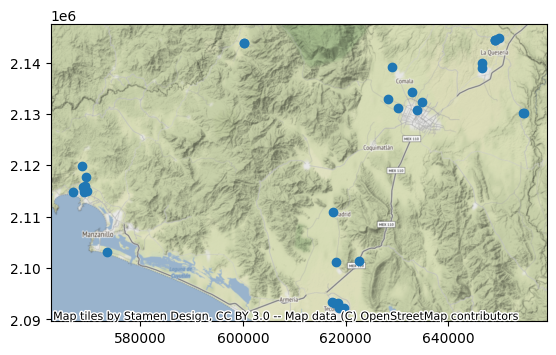

In [78]:
ax = agua_geo.plot()
cx.add_basemap(ax, crs=agua_geo.crs.to_string())

### Suelo

In [79]:
suelo_loc.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [80]:
suelo_data.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [81]:
suelo_geo = suelo_loc[["sitio_muestra",'id_muestra']]
suelo_geo = suelo_loc.merge(suelo_data, on="id_muestra")
suelo_geo.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y,V,Sb,Mn,Fe,Co,...,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0,52.119857,83.060767,356.421452,20380.124669,6.795681,...,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0,159.152316,276.315419,1005.076752,50577.530073,25.365117,...,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0,106.107911,126.982028,793.213865,37072.895524,16.139127,...,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0,102.633385,112.383905,559.905098,14572.771029,15.059621,...,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0,127.852641,156.285914,885.251725,19517.950289,20.335008,...,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [82]:
suelo_geo.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y,V,Sb,Mn,Fe,Co,...,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0,52.119857,83.060767,356.421452,20380.124669,6.795681,...,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0,159.152316,276.315419,1005.076752,50577.530073,25.365117,...,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0,106.107911,126.982028,793.213865,37072.895524,16.139127,...,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0,102.633385,112.383905,559.905098,14572.771029,15.059621,...,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0,127.852641,156.285914,885.251725,19517.950289,20.335008,...,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [83]:
# make suelo_geo from wide to long
suelo_geo_melted = suelo_geo.drop(columns=["sitio_muestra","fecha_muestra","x","y"]).melt(id_vars=["id_muestra"],
                            var_name="parametro",
                
                            value_name="valor")
suelo_geo_melted

,id_muestra,parametro,valor
0,TEC-SS-01,V,52.119857
1,TEC-SS-02,V,159.152316
2,TEC-SS-03,V,106.107911
3,TEC-SS-04,V,102.633385
4,TEC-SS-05,V,127.852641
...,...,...,...
930,MZN-SS-06,Pb,8.241509
931,MZN-SS-10,Pb,1253.844949
932,MZN-SS-14,Pb,5.933980
933,MZN-SS-15,Pb,145.991634


<Axes: xlabel='parametro', ylabel='valor'>

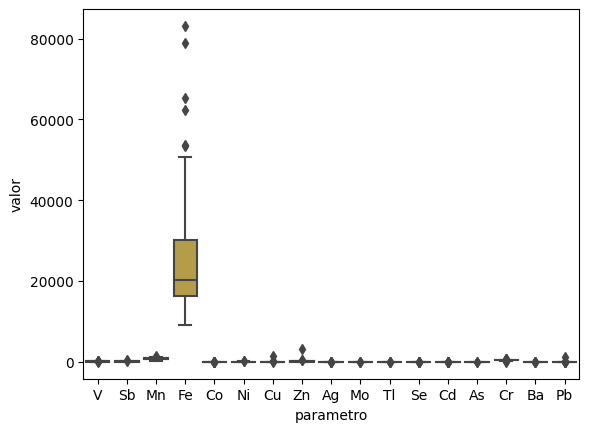

In [84]:
sns.boxplot(data=suelo_geo_melted, x="parametro", y="valor")


Eliminacmos "x", "y","fecha_muestra","id_muestra" ya que la interpolación solo requiere los valores, geometry y el sitio de muestra para interpolar sobre cada sitio de muestreo.

In [85]:
suelo_geo.columns

Index(['sitio_muestra', 'id_muestra', 'fecha_muestra', 'x', 'y', 'V', 'Sb',
       'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ag', 'Mo', 'Tl', 'Se', 'Cd', 'As',
       'Cr', 'Ba', 'Pb'],
      dtype='object')

In [86]:


## replace 6614368.0 from x
suelo_geo.loc[45, "x"] = 661436

suelo_geo = gpd.GeoDataFrame(suelo_geo, geometry=gpd.points_from_xy(suelo_geo.x, suelo_geo.y))

## reproject to epsg 103796
suelo_geo = suelo_geo.set_crs(epsg=32213)

suelo_geo = suelo_geo.drop(columns=["x", "y","fecha_muestra","id_muestra"])

suelo_geo.head()

,sitio_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb,geometry
0,Tecomán,52.119857,83.060767,356.421452,20380.124669,6.795681,31.372127,27.613830,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174,POINT (618792.000 2099659.000)
1,Tecomán,159.152316,276.315419,1005.076752,50577.530073,25.365117,89.874603,20.370812,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971,POINT (616997.000 2093272.000)
2,Tecomán,106.107911,126.982028,793.213865,37072.895524,16.139127,42.925982,17.016066,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398,POINT (619193.000 2093032.000)
3,Tecomán,102.633385,112.383905,559.905098,14572.771029,15.059621,41.513285,20.244953,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546,POINT (619103.000 2091339.000)
4,Tecomán,127.852641,156.285914,885.251725,19517.950289,20.335008,55.237631,21.196320,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604,POINT (616897.000 2089151.000)


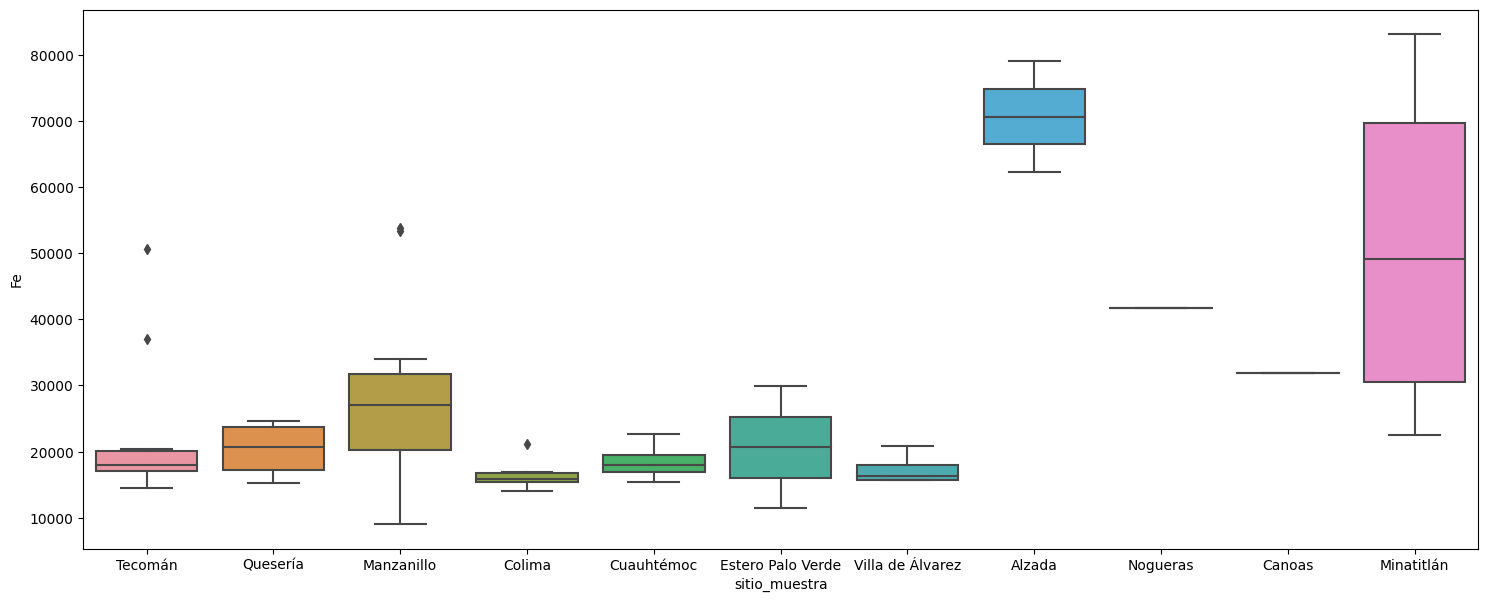

In [87]:
suelo_geo

fig, ax = plt.subplots(figsize=(18,7))
sns.boxplot(data=suelo_geo, x="sitio_muestra", y="Fe", ax=ax)

plt.show()

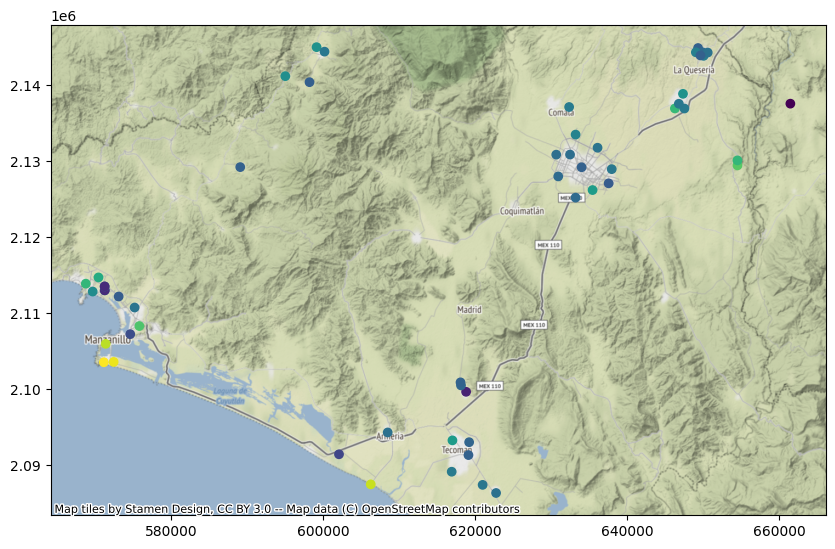

In [88]:
## show map
ax = suelo_geo.plot(column="V",figsize=(10, 10))

## set xlim and ylim to ax
xlim = suelo_geo.total_bounds[0::2]
#ax.set_xlim(660000, 670000)

minx, miny, maxx, maxy = suelo_geo.total_bounds
#ax.set_xlim(minx*0.5, maxx*1.5)
#ax.set_ylim(miny*0.8, maxy*1.2)


cx.add_basemap(ax, crs=suelo_geo.crs.to_string())

In [89]:
def interpolate_gdf(gdf, value, output, method = "cubic"):
    points = np.array([gdf.geometry.x, gdf.geometry.y]).T
    values = gdf[value]  # Reemplaza 'value' con el nombre de tu columna de valores

    # Definir la cuadrícula de interpolación
    minx, miny, maxx, maxy = gdf.total_bounds
    grid_x, grid_y = np.mgrid[minx:maxx:1000j, miny:maxy:1000j]  # Ajusta el tamaño de la cuadrícula según sea necesario

    # Interpolar los datos
    grid_z = griddata(points, values, (grid_x, grid_y), method=method)

    # Crear una transformación para la cuadrícula
    transform = from_origin(minx, maxy, (maxx-minx)/1000, (maxy-miny)/1000)  # Ajusta el tamaño de la cuadrícula según sea necesario

    # Guardar los datos interpolados como un GeoTIFF
    with rasterio.open(output, 'w', driver='GTiff', height=grid_z.shape[0],
                    width=grid_z.shape[1], count=1, dtype=str(grid_z.dtype),
                    crs=gdf.crs, transform=transform) as dst:
        dst.write(grid_z[::-1], 1)
    
    ## load interpolated raster 
    interpolated = rasterio.open(output)

    return interpolated

In [90]:
cols_metales = suelo_geo.columns[1:-1]
cols_metales


Index(['V', 'Sb', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ag', 'Mo', 'Tl', 'Se',
       'Cd', 'As', 'Cr', 'Ba', 'Pb'],
      dtype='object')

## Interpolación

In [91]:
for metal in cols_metales:
    output = f"data/sueloagua_informe15junio/interpolate/nearest_{metal}.tif"

    interpolated = interpolate_gdf(suelo_geo, metal, output, method = "nearest")

In [92]:
cols_metalesagua = agua_geo.columns[1:-3]
cols_metalesagua

Index(['As_agua', 'Ba_agua', 'Cd_agua', 'Cr_agua', 'Cu_agua', 'Fe_agua',
       'Hg_agua', 'Mn_agua', 'Ni_agua', 'Pb_agua', 'Se_agua'],
      dtype='object')

In [93]:
len(cols_metalesagua)

11

In [94]:
for metal in cols_metalesagua:
    output = f"data/sueloagua_informe15junio/interpolate/nearest_{metal}.tif"

    interpolated = interpolate_gdf(agua_geo, metal, output, method = "nearest")

## AGEBS

In [95]:
agebs0 = gpd.read_file("data/06_colima/06a.shx")

# reproject to epsg 32213
agebs0 = agebs0.to_crs(epsg=32213)

# keep same CVEGEO as sentinel_df
agebs0 = agebs0[agebs0.CVEGEO.isin(sentinel_df.CVEGEO.unique())]

agebs0.to_file("data/sueloagua_informe15junio/agebs.gpkg", driver="GPKG")
agebs0.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry
23,060020001134A,06,002,0001,134A,0.04,"POLYGON ((636989.319 2125629.933, 636967.430 2..."
24,0600200011640,06,002,0001,1640,0.16,"POLYGON ((635481.347 2132656.572, 635480.992 2..."
25,0600200011316,06,002,0001,1316,0.90,"POLYGON ((630616.281 2128069.243, 630688.991 2..."
26,0600200011320,06,002,0001,1320,1.11,"POLYGON ((630641.288 2127180.697, 630624.382 2..."
27,0600200011373,06,002,0001,1373,0.22,"POLYGON ((635865.829 2126651.341, 635865.785 2..."


#### zonal stats

In [96]:
zonal_stats = glob.glob("data/sueloagua_informe15junio/zonal_stats/*.gpkg")
zonal_stats[:5]

['data/sueloagua_informe15junio/zonal_stats\\zonal_ag.gpkg',
 'data/sueloagua_informe15junio/zonal_stats\\zonal_as.gpkg',
 'data/sueloagua_informe15junio/zonal_stats\\zonal_As_agua.gpkg',
 'data/sueloagua_informe15junio/zonal_stats\\zonal_ba.gpkg',
 'data/sueloagua_informe15junio/zonal_stats\\zonal_Ba_agua.gpkg']

In [97]:
cols_metales

Index(['V', 'Sb', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ag', 'Mo', 'Tl', 'Se',
       'Cd', 'As', 'Cr', 'Ba', 'Pb'],
      dtype='object')

In [98]:
cols_metalesagua

Index(['As_agua', 'Ba_agua', 'Cd_agua', 'Cr_agua', 'Cu_agua', 'Fe_agua',
       'Hg_agua', 'Mn_agua', 'Ni_agua', 'Pb_agua', 'Se_agua'],
      dtype='object')

In [99]:
zonal = 'data/sueloagua_informe15junio/zonal_stats\\zonal_ba.gpkg'

In [100]:
zonal.split("\\")[-1].split(".")[0][6:]

'ba'

In [101]:

agebs = agebs0.copy()
for zonal in zonal_stats:

    ## read zonal stats
    zonal_df = gpd.read_file(zonal)
    zonal_df = zonal_df[["CVEGEO","_mean"]]

    if zonal[-10:] == '_agua.gpkg':
        #zonal_df = zonal_df.rename(columns={"_mean":"agua"})
        name_metal = zonal.split("\\")[-1].split(".")[0][6:]

        zonal_df = zonal_df.rename(columns={"_mean":name_metal})

    else:
    #print(name_metal)
        name_metal = zonal.split("\\")[-1].split(".")[0][6:]
    
        for i in cols_metales:
            if name_metal == i.lower():
                zonal_df = zonal_df.rename(columns={"_mean":i})


    agebs = agebs.merge(zonal_df, on="CVEGEO")


colima_metricas = pd.merge(agebs, sentinel_df, on="CVEGEO")
colima_metricas["densidad"] = colima_metricas["POB_TOTAL"] / colima_metricas["area"]

In [102]:
agebs.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry,Ag,As,As_agua,...,Ni,Ni_agua,Pb,Pb_agua,Sb,Se,Se_agua,Tl,V,Zn
0,060020001134A,06,002,0001,134A,0.04,"POLYGON ((636989.319 2125629.933, 636967.430 2...",2.079606,0.752745,0.000904,...,54.746620,0.000039,5.317871,NaN,132.310057,0.304258,0.000026,0.794859,115.086376,89.449464
1,0600200011640,06,002,0001,1640,0.16,"POLYGON ((635481.347 2132656.572, 635480.992 2...",1.941988,1.083169,0.001103,...,36.609201,0.000064,6.201300,NaN,100.040264,0.217692,NaN,0.920498,124.955622,108.546794
2,0600200011316,06,002,0001,1316,0.90,"POLYGON ((630616.281 2128069.243, 630688.991 2...",3.538029,1.109542,0.000904,...,65.675231,0.000039,5.190053,NaN,206.879391,0.224084,0.000026,2.665846,116.931562,111.609775
3,0600200011320,06,002,0001,1320,1.11,"POLYGON ((630641.288 2127180.697, 630624.382 2...",3.316143,1.078777,0.000904,...,65.838629,0.000039,4.801673,NaN,206.977802,0.222800,0.000026,2.856229,112.016271,104.314004
4,0600200011373,06,002,0001,1373,0.22,"POLYGON ((635865.829 2126651.341, 635865.785 2...",1.506660,0.888300,0.000904,...,48.766140,0.000039,5.560425,NaN,141.916710,0.097995,0.000026,1.133612,111.921580,90.586440


In [103]:
# import minmax scaler from sklearn
from sklearn.preprocessing import MinMaxScaler
colima_metricas.NOM_LOC.unique()

array(['Colima', 'Cuauhtémoc', 'Quesería', 'Manzanillo', 'Minatitlán',
       'Tecomán', 'Ciudad de Villa de Álvarez'], dtype=object)

In [104]:
colima_metricas.columns

Index(['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'area',
       'geometry', 'Ag', 'As', 'As_agua', 'Ba', 'Ba_agua', 'Cd', 'Cd_agua',
       'Co', 'Cr', 'Cr_agua', 'Cu', 'Cu_agua', 'Fe', 'Fe_agua', 'Hg_agua',
       'Mn', 'Mn_agua', 'Mo', 'Ni', 'Ni_agua', 'Pb', 'Pb_agua', 'Sb', 'Se',
       'Se_agua', 'Tl', 'V', 'Zn', '$CO$', '$HCHO$', '$NO_2$', '$O_3$',
       '$SO_2$', 'NOM_ENT', 'NOM_MUN', 'NOM_LOC', 'POB_TOTAL', 'GM_2020',
       'densidad'],
      dtype='object')

In [105]:
cols_to_normalize = ['Ag', 'As', 'As_agua', 'Ba', 'Ba_agua', 'Cd', 'Cd_agua',
       'Co', 'Cr', 'Cr_agua', 'Cu', 'Cu_agua', 'Fe', 'Fe_agua', 'Hg_agua',
       'Mn', 'Mn_agua', 'Mo', 'Ni', 'Ni_agua', 'Pb', 'Pb_agua', 'Sb', 'Se',
       'Se_agua', 'Tl', 'V', 'Zn', '$CO$', '$HCHO$', '$NO_2$', '$O_3$',
       '$SO_2$',"GM_2020", "densidad"]
colima_metricas.NOM_LOC.unique()

array(['Colima', 'Cuauhtémoc', 'Quesería', 'Manzanillo', 'Minatitlán',
       'Tecomán', 'Ciudad de Villa de Álvarez'], dtype=object)

In [106]:
colima_metricas[cols_to_normalize] = colima_metricas[cols_to_normalize].round(3)

In [107]:
df_mun = pd.DataFrame()

for mun in colima_metricas.NOM_MUN.unique():
  scaler = MinMaxScaler()
  df = colima_metricas[colima_metricas["NOM_MUN"] == mun].copy()
  
  # normalize data by max min scaler
  df.loc[:, cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
  
  # sum all metrics if value is not null


  df["metrica"] = df[cols_to_normalize].sum(axis=1 , skipna = True)

  # check the number of cell of each row that are not null and sum them
  df["num_notnull"] = df[cols_to_normalize].notnull().sum(axis=1)
  df["metrica"] = df["metrica"] / df["num_notnull"]

  df_mun = pd.concat([df_mun, df.sort_values(by="metrica", ascending=False).head(5)])


df_mun = gpd.GeoDataFrame(df_mun)
df_mun.head()

c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sk

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry,Ag,As,As_agua,...,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020,densidad,metrica,num_notnull
52,060020001127A,06,002,0001,127A,0.46,"POLYGON ((632857.181 2128295.295, 632857.309 2...",1.000000,0.405388,0.0,...,0.242518,0.225,Colima,Colima,Colima,1258,0.25,0.184103,0.551410,32
97,0600200010731,06,002,0001,0731,0.36,"POLYGON ((633010.285 2128570.832, 633007.707 2...",1.000000,0.405388,0.0,...,0.182940,0.150,Colima,Colima,Colima,2350,0.00,0.446583,0.541942,32
92,0600200011513,06,002,0001,1513,0.59,"POLYGON ((632827.412 2127906.118, 632812.594 2...",0.944209,0.385965,0.0,...,0.322620,0.300,Colima,Colima,Colima,708,0.00,0.077894,0.539966,32
40,0600200010746,06,002,0001,0746,0.44,"POLYGON ((634055.869 2127746.835, 633952.189 2...",0.917808,0.355890,0.0,...,0.232149,0.225,Colima,Colima,Colima,942,0.00,0.143006,0.504686,32
103,0600200011176,06,002,0001,1176,0.69,"POLYGON ((632117.398 2128338.269, 632099.312 2...",0.710834,0.304511,0.0,...,0.367903,0.325,Colima,Colima,Colima,2717,0.00,0.267345,0.499525,32


In [108]:
# AG

MAX = 983# -> 1 
MIN = 45 # -> 0




In [120]:
df_mun.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry,Ag,As,As_agua,...,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020,densidad,metrica,num_notnull
52,060020001127A,06,002,0001,127A,0.46,"POLYGON ((632857.181 2128295.295, 632857.309 2...",1.000000,0.405388,0.0,...,0.242518,0.225,Colima,Colima,Colima,1258,0.25,0.184103,0.551410,32
97,0600200010731,06,002,0001,0731,0.36,"POLYGON ((633010.285 2128570.832, 633007.707 2...",1.000000,0.405388,0.0,...,0.182940,0.150,Colima,Colima,Colima,2350,0.00,0.446583,0.541942,32
92,0600200011513,06,002,0001,1513,0.59,"POLYGON ((632827.412 2127906.118, 632812.594 2...",0.944209,0.385965,0.0,...,0.322620,0.300,Colima,Colima,Colima,708,0.00,0.077894,0.539966,32
40,0600200010746,06,002,0001,0746,0.44,"POLYGON ((634055.869 2127746.835, 633952.189 2...",0.917808,0.355890,0.0,...,0.232149,0.225,Colima,Colima,Colima,942,0.00,0.143006,0.504686,32
103,0600200011176,06,002,0001,1176,0.69,"POLYGON ((632117.398 2128338.269, 632099.312 2...",0.710834,0.304511,0.0,...,0.367903,0.325,Colima,Colima,Colima,2717,0.00,0.267345,0.499525,32


In [109]:
final = df_mun.copy()
final = final[["NOM_ENT","NOM_MUN","NOM_LOC","CVE_AGEB","POB_TOTAL","metrica"]]
final.to_excel("data/sueloagua_informe15junio/reporte_final.xlsx", index=False)

<Axes: >

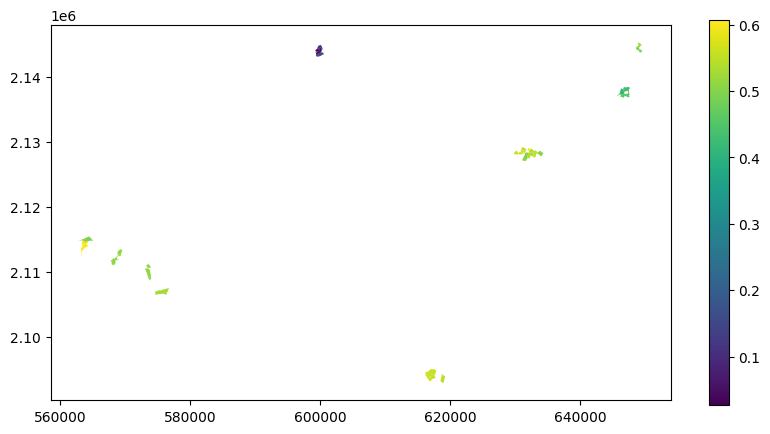

In [113]:
df_mun.plot(column="metrica", figsize=(10,5), legend=True)

## Maps

In [119]:
background = gpd.read_file("data/06_colima/06a.shx")
background = background.to_crs(epsg=32213)

background.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry
0,0600100010081,06,001,0001,0081,0.28,"POLYGON ((608933.000 2094642.832, 608933.952 2..."
1,060010001019A,06,001,0001,019A,0.15,"POLYGON ((609259.077 2094715.816, 609264.401 2..."
2,0600100010359,06,001,0001,0359,0.05,"POLYGON ((608186.519 2095102.992, 608181.685 2..."
3,0600100010151,06,001,0001,0151,0.42,"POLYGON ((608847.277 2095141.382, 608866.980 2..."
4,0600100010166,06,001,0001,0166,0.41,"POLYGON ((610132.336 2094624.651, 610132.979 2..."


In [124]:
mun_dic = {
    '001': 'Armería',
    '002': 'Colima',
    '003': 'Comala',
    '004': 'Coquimatlán',
    '005': 'Cuauhtémoc',
    '006': 'Ixtlahuacán',
    '007': 'Manzanillo',
    '008': 'Minatitlán',
    '009': 'Tecomán',
    '010': 'Villa de Álvarez'
}

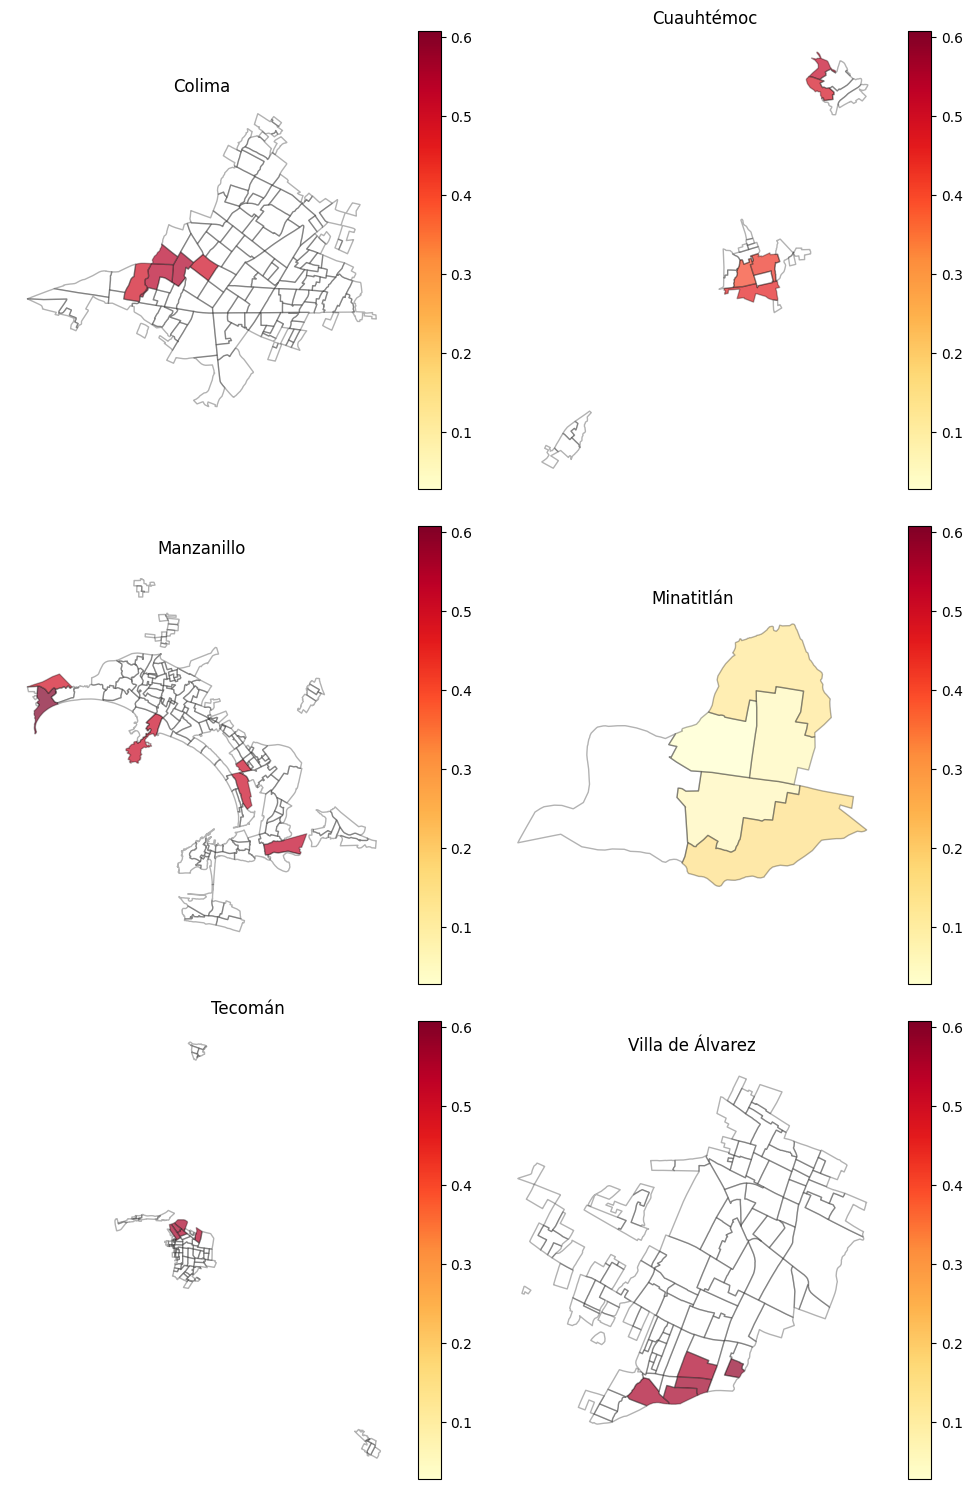

In [125]:
n_muns = len(df_mun.CVE_MUN.unique())
n_muns

nrows = int(np.ceil(n_muns/2))
ncols = 2

vmin, vmax = df_mun.metrica.min(), df_mun.metrica.max()

## keep a proportion of 2:1 for each subplot
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5*nrows))

for i, mun in enumerate(df_mun.CVE_MUN.unique()):
    ax = axs[int(i/2), i%2]
    df = df_mun[df_mun["CVE_MUN"] == mun]
    df.plot(column="metrica", ax=ax, legend=True, vmin=vmin, vmax=vmax, cmap="YlOrRd")

    background_mun = background[background["CVE_MUN"] == mun]
    background_mun.plot(ax=ax, color="white", edgecolor="black", alpha=0.3)
    ax.set_title(mun_dic[mun])
    ax.set_axis_off()

plt.tight_layout() 

#plt.savefig("data/sueloagua_informe15junio/figures/colima.png", dpi=300)
plt.show()

In [122]:
background_mun

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,geometry
435,0601000010841,06,010,0001,0841,0.06,"POLYGON ((629496.943 2127676.643, 629500.017 2..."
436,0601000010536,06,010,0001,0536,0.09,"POLYGON ((633794.609 2132991.157, 633784.628 2..."
437,0601000010150,06,010,0001,0150,0.42,"POLYGON ((633436.651 2129946.420, 633424.967 2..."
438,060100001017A,06,010,0001,017A,0.15,"POLYGON ((632553.659 2129295.547, 632544.990 2..."
439,0601000010790,06,010,0001,0790,0.18,"POLYGON ((630252.358 2128018.730, 630091.893 2..."
...,...,...,...,...,...,...,...
546,0601000011017,06,010,0001,1017,0.21,"POLYGON ((634610.841 2133259.624, 634544.631 2..."
547,0601000011178,06,010,0001,1178,0.08,"POLYGON ((632174.702 2133539.791, 632153.407 2..."
548,0601000011144,06,010,0001,1144,0.39,"POLYGON ((630227.628 2132472.217, 630201.639 2..."
549,060100001113A,06,010,0001,113A,0.32,"POLYGON ((630288.168 2130704.693, 630271.718 2..."
